In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from sklearn import preprocessing
#tf.logging.set_verbosity(tf.logging.INFO)


In [20]:

skip_vector_dim = 5
n_y = 1 #Numero di output, Per ora sali / scendi poi metteremo neutrale


class MyModel():
    
    def __init__(self, num_lstm_units, num_lstm_layers, news_per_hour, learning_rate = 0.009,
              num_epochs = 30, minibatch_size = 128):
        self.num_lstm_units = num_lstm_units
        self.num_lstm_layers = num_lstm_layers
        self.news_per_hour = news_per_hour
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        
        

    ## Managing state through batches:
    def get_state_variables(self, state_placeholder):
        l = tf.unstack(state_placeholder, axis=0)
        rnn_tuple_state = tuple(
        [tf.nn.rnn_cell.LSTMStateTuple(l[idx][0], l[idx][1])
         for idx in range(self.num_lstm_layers)]
        )
        return rnn_tuple_state

    def get_initial_state(self):
        if(self.num_lstm_layers == 1):
            return np.zeros([self.num_lstm_layers, 2, 1, self.num_lstm_units])

        return tuple([tf.nn.rnn_cell.LSTMStateTuple(np.zeros([1, 1, self.num_lstm_units]), np.zeros([1, 1, self.num_lstm_units]))for idx in range(self.num_lstm_layers)])



    def create_placeholders(self):
        X = tf.placeholder(tf.float32, shape=(None, self.news_per_hour, skip_vector_dim), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, n_y), name='Y')
        lstm_state_placeholder = tf.placeholder(tf.float32, [self.num_lstm_layers, 2, None, self.num_lstm_units],  name='lstm_state')
        
        return X, Y, lstm_state_placeholder



    def forward_propagation(self, X, init_state = None):

        if init_state != None:
            init_state = self.get_state_variables(init_state)

        # ATTENTION
        e = tf.layers.dense(inputs=X, units=1, activation=tf.nn.relu)
        alpha = tf.nn.softmax(e, name='attention_weights')   												# tf.nn.softmax(logits,axis=None, ..)
        timeSlotEmbeddings =  tf.matmul(alpha, X, transpose_a=True, name='timeSlotEmbeddings')				# tf.matmul(a,b, transpose_a=False, transpose_b=False, name=None )

        # # LSTM
        # # (see https://jasdeep06.github.io/posts/Understanding-LSTM-in-Tensorflow-MNIST/)

        timeSlotSequence = timeSlotEmbeddings															# 1 sequenza di ? sample timeSlotEmbeddings.shape = (?, 1, 2400) -> memoria tra i vari sample


        # VEDERE COME FUNZIONA BACKPROP THROUGH TIME PER VEDERE QUALE E MEGLIO
        #timeSlotSequence = tf.transpose(timeSlotEmbeddings, perm=[1, 0, 2])								# ? sequenze di 1 sample -> NON c'e memoria esplicita tra i vari sample

        #lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_lstm_units)											# Definisco il layer
        lstm_layer = tf.contrib.rnn.LSTMCell(self.num_lstm_units, use_peepholes=True)						# Definisco il layer

        lstm_network = tf.contrib.rnn.MultiRNNCell([lstm_layer] * self.num_lstm_layers)


        outputs, new_states = tf.nn.dynamic_rnn(lstm_network, timeSlotSequence,
             initial_state=init_state,  dtype="float32",time_major=True)									# Definisco la rete ricorrente tramite il layer precedente


        outputs = tf.squeeze(outputs, axis=1)
    #		outputs = tf.squeeze(outputs, axis=0)

        prediction = tf.layers.dense(outputs, 1, activation=tf.nn.sigmoid)


        return prediction, new_states



    def compute_cost(self, Y_hat, Y):
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_hat, labels = Y))		# Y * -log(sigmoid(Y_hat)) + (1 - Y) * -log(1 - sigmoid(Y_hat))
        #cost = tf.reduce_mean(tf.squared_difference(Y_hat, Y))
        return cost



    def random_mini_batches(self, X_train, Y_train):
        minibatches = list()

        m = int(len(X_train))
        if(self.minibatch_size > m):
            minibatches.append((X_train, Y_train))
            return minibatches

        minibatches.append((X_train[0:self.minibatch_size], Y_train[0:self.minibatch_size]))
        iterSize = self.minibatch_size
        while(iterSize < m):
            if(iterSize+self.minibatch_size < m):
                minibatches.append((X_train[iterSize:iterSize+self.minibatch_size], Y_train[iterSize:iterSize+self.minibatch_size]))
                iterSize += self.minibatch_size
            else:
                minibatches.append((X_train[iterSize:m],Y_train[iterSize:m]))
                iterSize = m
        return minibatches


    def run(self, X_train, Y_train, X_dev, Y_dev, X_test=None, Y_test=None, set_verbosity=True):
        
        if(set_verbosity):
            print ("Learning rate: " +str(self.learning_rate))

        ops.reset_default_graph()                      										# to be able to rerun the model without overwriting tf variables
        m =int(len(X_train))
        costs_train = []
        costs_dev = []
        cost_minibatches=[]
        accuracy_train = []
        accuracy_dev = []

        # Create Placeholders of the correct shape
        X, Y, lstm_state_placeholder = self.create_placeholders()

        # Forward propagation: Build the forward propagation in the tensorflow graph
        prediction, lstm_next_state = self.forward_propagation(X, lstm_state_placeholder)	


        # Cost function: Add cost function to tensorflow graph
        cost = self.compute_cost(prediction, Y)

        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(cost)
        #grads = tf.train.AdamOptimizer(learning_rate = learning_rate).compute_gradients(cost)

        # Initialize all the variables globally
        init = tf.global_variables_initializer()

        #This is for computing the test accuracy every epoch
        predict_op = tf.to_float(prediction > 0.5)
        correct_prediction = tf.equal(predict_op, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


        # Start the session to compute the tensorflow graph
        with tf.Session() as sess:
            sess.run(init)


          # Do the training loop
            for epoch in range(self.num_epochs):
                # 1 perche per ora ho 1 sola sequenza
                lstm_state = self.get_initial_state()
                #lstm_state = np.zeros([num_lstm_layers, 2, 1, num_lstm_units])														#Ogni epoch reinizializzo stato

                minibatch_cost = 0.0
                num_minibatches = int(m / self.minibatch_size)
                if(num_minibatches == 0):
                    num_minibatches = 1
                minibatches = self.random_mini_batches(X_train, Y_train)


                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    minibatch_X = np.asarray(minibatch_X)
                    minibatch_Y = np.asarray(minibatch_Y).reshape((len(minibatch_Y), 1))



                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _ , temp_cost, lstm_state = sess.run([optimizer, cost, lstm_next_state], feed_dict={X: minibatch_X, Y: minibatch_Y, lstm_state_placeholder: lstm_state})


                    # weights = tf.get_default_graph().get_tensor_by_name('dense_1/kernel:0')
                    #print('state: ' +str(new_state))

                    minibatch_cost += temp_cost / num_minibatches

                # Print the cost every epoch
                if  epoch % 1 == 0:

                    lstm_temp_state = self.get_initial_state()
                    trainCost, lstm_temp_state = sess.run([cost, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_train.append(trainCost)
                    devCost = sess.run(cost, feed_dict={X: np.asarray(X_dev), Y: np.asarray(Y_dev).reshape((len(Y_dev), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_dev.append(devCost)

                    lstm_temp_state  = self.get_initial_state()
                    trainAccuracy, lstm_temp_state = sess.run([accuracy, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)),lstm_state_placeholder: lstm_temp_state})
                    devAccuracy = sess.run(accuracy, feed_dict={X: np.asarray(X_dev), Y: np.asarray(Y_dev).reshape((len(Y_dev), 1)),lstm_state_placeholder: lstm_temp_state})
                    accuracy_train.append(float(trainAccuracy))
                    accuracy_dev.append(float(devAccuracy))
                if  set_verbosity and epoch % 5 == 0:
                    print('miniCost ='+str(minibatch_cost))
                    print("Epoch "+str(epoch)+": \tTrain cost: "+str(trainCost)+" \tDev cost: "+str(devCost)+" \tTrain Accuracy: "+str(trainAccuracy)+" \tDev accuracy: "+str(devAccuracy))



        if(X_test != None and Y_test != None):
            costs_train = []
            costs_test = []
            cost_minibatches=[]
            accuracy_train = []
            accuracy_test = []
            #Retrain untill the optimal num_epochs accuracy on the dev
            with tf.Session() as sess:
                sess.run(init)
                for epoch in range(np.argmax(accuracy_dev)+1):
                    lstm_state = self.get_initial_state()
                    minibatch_cost = 0.0
                    num_minibatches = int(m / self.minibatch_size)
                    if(num_minibatches == 0):
                        num_minibatches = 1
                    minibatches = self.random_mini_batches(X_train, Y_train)
                    for minibatch in minibatches:
                        (minibatch_X, minibatch_Y) = minibatch
                        minibatch_X = np.asarray(minibatch_X)
                        minibatch_Y = np.asarray(minibatch_Y).reshape((len(minibatch_Y), 1))
                        _ , temp_cost, lstm_state = sess.run([optimizer, cost, lstm_next_state], feed_dict={X: minibatch_X, Y: minibatch_Y, lstm_state_placeholder: lstm_state})
                        minibatch_cost += temp_cost / num_minibatches

                    lstm_temp_state = self.get_initial_state()
                    trainCost, lstm_temp_state = sess.run([cost, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_train.append(trainCost)
                    devCost, lstm_temp_state = sess.run([cost, lstm_next_state], feed_dict={X: np.asarray(X_dev), Y: np.asarray(Y_dev).reshape((len(Y_dev), 1)), lstm_state_placeholder: lstm_temp_state})
                    testCost = sess.run(cost, feed_dict={X: np.asarray(X_test), Y: np.asarray(Y_test).reshape((len(Y_test), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_test.append(testCost)

                    lstm_temp_state  = self.get_initial_state()
                    trainAccuracy, lstm_temp_state = sess.run([accuracy, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)),lstm_state_placeholder: lstm_temp_state})
                    devAccuracy, lstm_temp_state = sess.run([accuracy, lstm_next_state], feed_dict={X: np.asarray(X_dev), Y: np.asarray(Y_dev).reshape((len(Y_dev), 1)),lstm_state_placeholder: lstm_temp_state})
                    testAccuracy = sess.run(accuracy, feed_dict={X: np.asarray(X_test), Y: np.asarray(Y_test).reshape((len(Y_test), 1)),lstm_state_placeholder: lstm_temp_state})
                    accuracy_train.append(float(trainAccuracy))
                    accuracy_test.append(float(testAccuracy))
                    
                    if  set_verbosity and epoch % 5 == 0:
                        print('miniCost ='+str(minibatch_cost))
                        print("Epoch "+str(epoch)+": \tTrain cost: "+str(trainCost)+" \tTest cost: "+str(testCost)+" \tTrain Accuracy: "+str(trainAccuracy)+" \tTest accuracy: "+str(testAccuracy))

                if(set_verbosity):
                    plt.figure(figsize=(20,10))
                    plt.plot(range(0,len(accuracy_train)), accuracy_train,'b', label='accuracy_train')
                    plt.plot(range(0,len(accuracy_test)), accuracy_test,'r', label='accuracy_test')
                    plt.plot(range(0,len(costs_train)),costs_train,'--b', label='cost_train')
                    plt.plot(range(0,len(costs_test)),costs_test,'--r', label='cost_test' )

                    plt.ylabel('accuracy')
                    plt.xlabel('epochs')
                    plt.title("Learning rate =" + str(self.learning_rate))
                    plt.legend()
                    plt.show()
                    print("Train Accuracy:", accuracy_train[-1])
                    print("Test Accuracy:",  accuracy_test[-1])
                return (accuracy_train[-1], accuracy_test[-1])
            
        else:
            if(set_verbosity):
                print("Train Accuracy:", max(accuracy_train))
                print("Dev Accuracy:",  max(accuracy_dev))
            return (max(accuracy_train), max(accuracy_dev))



In [16]:
class ModelSelection():

    def modelSelection(iterations = 400, learning_rate = 0.001, minibatch_size = 512 ):
        import os
        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        tf.logging.set_verbosity(tf.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        best_NumLSTMUnits = 0
        best_news_per_hour = 0
        best_X_window_average = 0
        best_newsTimeToMarket = 0
        
        
        bestAccuracy = 0
        # Each day: 7 hours of trading
        for i in range(0,iterations):
            news_per_hour = np.asscalar(np.random.random_integers(10, 40))
            X_window_average = np.asscalar(np.random.random_integers(10, 40))
            newsTimeToMarket = np.asscalar(np.random.random_integers(0, 50))
            # newsTimeToMarket = 0
            numLSTMUnits = np.asscalar(np.random.random_integers(100, 1000))

            print('NewsHour: '+str(news_per_hour)+' \tXavg: '+str(X_window_average)+' \t newsTTM: '+str(newsTimeToMarket)+
                  '\t LSTMUnits: '+str(numLSTMUnits)+'\t lr: '+str(learning_rate)+'\t miniBatch: '+str(minibatch_size))
            
            
            Data.load_data(news_per_hour = news_per_hour, X_window_average=X_window_average,
                           momentum_window=30, newsTimeToMarket = newsTimeToMarket, set_verbosity=False)

            folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)

            k_fold_train_accuracy = []
            k_fold_dev_accuracy = []
            always_yes = []

            for fold in folds:
                print("==", end="", flush=True)
                (X_train, Y_train), (X_dev, Y_dev) = fold
                model = MyModel(num_lstm_units=numLSTMUnits, num_lstm_layers=1, news_per_hour = news_per_hour,
                                learning_rate = learning_rate, minibatch_size = minibatch_size,
                                num_epochs = 30)
                
                (train_accuracy, dev_accuracy) = model.run(X_train=X_train, Y_train=Y_train,X_dev=X_dev,
                                                           Y_dev=Y_dev, set_verbosity=False)

                k_fold_train_accuracy.append(train_accuracy)
                k_fold_dev_accuracy.append(dev_accuracy)
                always_yes.append(np.sum(np.asarray(Y_dev)==1)/len(Y_dev))
            print('( train_fold_accuracy: '+str(sum(k_fold_train_accuracy) / len(folds))+ ', dev_fold_accuracy: '+str(sum(k_fold_dev_accuracy) / len(folds))+' )')
            print('Dev accuracies: '+str(k_fold_dev_accuracy))
            print('Dev predict y=1: '+str(always_yes))
            print('( train_fold_variance: '+str(np.var(np.asarray(k_fold_train_accuracy)))+ ', dev_fold_variance: '+str(np.var(np.asarray(k_fold_dev_accuracy)))+' )')

            if(dev_accuracy > bestAccuracy):
                best_NumLSTMUnits = numLSTMUnits
                best_news_per_hour = news_per_hour
                best_X_window_average = X_window_average
                best_newsTimeToMarket = newsTimeToMarket

        print('#################################\n')
        print('BEST:')
        print('best_NumLSTMUnits: '+str(best_NumLSTMUnits))
        print('best_news_per_hour: '+str(best_news_per_hour))
        print('best_X_window_average: '+str(best_X_window_average))
        print('best_newsTimeToMarket: '+str(best_newsTimeToMarket))
        
        print('\n#################################\n')
                    
        print('Training optimal model...')
        Data.load_data(news_per_hour = best_news_per_hour, X_window_average=best_X_window_average,
                       momentum_window=30, newsTimeToMarket = best_newsTimeToMarket)
        _ , (X_test, Y_test) = Data.get_train_test_set()
        
        #For training I take the biggest fold, validation on dev for early stopping (opt num epochs)
        folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)
        (X_train, Y_train), (X_dev, Y_dev) = folds[-1] 
        
        model = MyModel(num_lstm_units=best_NumLSTMUnits, num_lstm_layers=1, news_per_hour = best_news_per_hour,
                        learning_rate = learning_rate, minibatch_size = minibatch_size, num_epochs = 30)
        
        model.run(X_train, Y_train,X_dev, Y_dev, X_test, Y_test)
        

    def modelSelectionFixedTTM(ticker='AAPL', iterations = 20, learning_rate = 0.001, minibatch_size = 512):
        import os
        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        tf.logging.set_verbosity(tf.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        best_NumLSTMUnits = []
        best_news_per_hour = []
        best_X_window_average = []
        
        Ttm_range = [0, 7, 14, 21, 35, 70, 105,210]

        
        bestAccuracy = 0
        # Each day: 7 hours of trading
        for newsTimeToMarketIndex in range(0, len(Ttm_range)):
            newsTimeToMarket = Ttm_range[newsTimeToMarketIndex]
            
            best_NumLSTMUnits.append(0)
            best_news_per_hour.append(0)
            best_X_window_average.append(0)
            
#             print('\n\n\n *****************  Predicting the future at '+str(newsTimeToMarket/7)+' days ****************')
            for i in range(0,iterations):
                news_per_hour = np.asscalar(np.random.random_integers(10, 40))
                X_window_average = np.asscalar(np.random.random_integers(10, 70))
                numLSTMUnits = np.asscalar(np.random.random_integers(200, 500))

                Data.load_data(ticker= ticker, news_per_hour = news_per_hour, X_window_average=X_window_average,
                               momentum_window=30, newsTimeToMarket = newsTimeToMarket, set_verbosity=False)

                folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)

#                 print('NewsHour: '+str(news_per_hour)+' \tXavg: '+str(X_window_average)+' \t newsTTM: '+str(newsTimeToMarket)+
#                   '\t LSTMUnits: '+str(numLSTMUnits)+'\t lr: '+str(learning_rate)+'\t miniBatch: '+str(minibatch_size))
            
                k_fold_train_accuracy = []
                k_fold_dev_accuracy = []
                always_yes = []

                for fold in folds:
                    print("==", end="", flush=True)
                    (X_train, Y_train), (X_dev, Y_dev) = fold
                    model = MyModel(num_lstm_units=numLSTMUnits, num_lstm_layers=1, news_per_hour = news_per_hour,
                                learning_rate = learning_rate, num_epochs = 30, minibatch_size = minibatch_size)
                
                    (train_accuracy, dev_accuracy) = model.run(X_train,Y_train,X_dev,Y_dev, set_verbosity=False)
                    
                    
                    k_fold_train_accuracy.append(train_accuracy)
                    k_fold_dev_accuracy.append(dev_accuracy)
                    always_yes.append(np.sum(np.asarray(Y_dev)==1)/len(Y_dev))
#                 print('( train_fold_accuracy: '+str(sum(k_fold_train_accuracy) / len(folds))+ ', dev_fold_accuracy: '+str(sum(k_fold_dev_accuracy) / len(folds))+' )')
#                 print('( train_fold_variance: '+str(np.var(np.asarray(k_fold_train_accuracy)))+ ', dev_fold_variance: '+str(np.var(np.asarray(k_fold_dev_accuracy)))+' )')

            if(dev_accuracy > bestAccuracy):
                best_NumLSTMUnits[newsTimeToMarketIndex] = numLSTMUnits
                best_news_per_hour[newsTimeToMarketIndex] = news_per_hour
                best_X_window_average[newsTimeToMarketIndex] = X_window_average
                

        print('\n#################################\n')
        print('BEST:')
        print('Predicting the future at: '+str(np.asarray(Ttm_range)/7)+' days')
        print('best_NumLSTMUnits: '+str(best_NumLSTMUnits))
        print('best_news_per_hour: '+str(best_news_per_hour))
        print('best_X_window_average: '+str(best_X_window_average))
        print('\n#################################\n')
                    
        print('Training optimal model...')
        train_accs = []
        test_accs = []
        for newsTimeToMarketIndex in range(0, len(Ttm_range)):
            newsTimeToMarket = Ttm_range[newsTimeToMarketIndex]
            Data.load_data(ticker= ticker, news_per_hour = best_news_per_hour[newsTimeToMarketIndex],
                           X_window_average=best_X_window_average[newsTimeToMarketIndex],
                           momentum_window=30, newsTimeToMarket = newsTimeToMarket, set_verbosity=False)
            _ , (X_test, Y_test) = Data.get_train_test_set()
            
            #For training I take the biggest fold, validation on dev for early stopping (opt num epochs)
            folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)
            (X_train, Y_train), (X_dev, Y_dev) = folds[-1] 
            
            model = MyModel(num_lstm_units=best_NumLSTMUnits[newsTimeToMarketIndex], num_lstm_layers=1,
                            news_per_hour = best_news_per_hour[newsTimeToMarketIndex],learning_rate = learning_rate,
                            num_epochs = 30, minibatch_size = minibatch_size)
                
            (train_accuracy, test_accuracy) = model.run(X_train,Y_train, X_dev, Y_dev, X_test, Y_test, set_verbosity=False)
            
            train_accs.append(train_accuracy)
            test_accs.append(test_accuracy)
        plt.figure(figsize=(20,10))
        plt.plot(Ttm_range,train_accs,'b', label='accuracy_train')
        plt.plot(Ttm_range,test_accs,'r', label='accuracy_test' )

        plt.ylabel('accuracy')
        plt.xlabel('hours in the future')
        #plt.title("Accuracy moving the window")
        plt.legend()
        plt.show()

In [17]:
# PREV---------------------------------
# X_path = '/home/simone/Desktop/wordCountEmbedding.json'
# Y_path = '../../DataSetIndexes/indexesAAPL.csv'
# - X -> read csv
# - model sel TTM -> test verbosity false
# - all params for the ticker
# - removed +%f from x to datetime


def sign(x):
    if x >= 0:
        return 1
    elif x < 0:
        #return -1
        return 0
    
class Data():
    X = []
    Y = []


    def get_train_test_set(test_percentage=0.3):
        idx_split = math.floor(len(Data.X)*(1-test_percentage))

        train_x = Data.X[:idx_split]
        train_y = Data.Y[:idx_split]
        test_x = Data.X[idx_split:]
        test_y = Data.Y[idx_split:]

        return (train_x, train_y), (test_x, test_y)



    def get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 10,  dev_num_points=100):

        # https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection/14109#14109


        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        (train_x, train_y), _  = Data.get_train_test_set(test_percentage=test_percentage)
        m = int(len(train_x))
        samples_per_fold = int( (m - dev_num_points) / k_fold)
        # print('Fold lenght: '+str(samples_per_fold))
        fold = list()
        index = 0
        while(len(fold) < k_fold):
            # Training folds of equal length:
#           fold.append(((train_x[index:index+samples_per_fold], train_y[index:index+samples_per_fold]),
#                 (train_x[index+samples_per_fold:index+samples_per_fold+dev_num_points], train_y[index+samples_per_fold:index+samples_per_fold+dev_num_points])))
            fold.append(((train_x[0:index+samples_per_fold], train_y[0:index+samples_per_fold]),
                (train_x[index+samples_per_fold:index+samples_per_fold+dev_num_points], train_y[index+samples_per_fold:index+samples_per_fold+dev_num_points])))
            index += samples_per_fold

        return fold
    
    
    def load_data(ticker='AAPL', momentum_window=30, X_window_average=None, news_per_hour = 10, newsTimeToMarket = 0, set_verbosity=True):
        X_path = '/home/simone/Desktop/NLFF/sentiment/myTools/wordCount+KSVM/SentimentSingleNewsFull/'+str(ticker)+'.csv'
        Y_path = '/home/simone/Desktop/NLFF/indexes/indexes'+str(ticker)+'.csv'
        
        
        if(set_verbosity):
            print('Reading dataset...')
            
        x = pd.read_csv(X_path)
        x.drop('Unnamed: 0', axis=1, inplace=True)

        x = x.rename(index=str, columns={"initTime": "PUBLICATION_DATE"})
    
        ##cambio l'ordine dalla piu vecchia alla piu recente
        if(set_verbosity):
            print('Ordering dataset...')
        x = x.sort_values(by=['PUBLICATION_DATE'])
        x = x.reset_index(drop=True)
        
        if(X_window_average != None):
            if(set_verbosity):
                print('Moving average..')
            x['CONSTRAINING'] = x['CONSTRAINING'].rolling(window=X_window_average,center=False).mean()
            x['LITIGIOUS'] = x['LITIGIOUS'].rolling(window=X_window_average,center=False).mean()
            x['NEGATIVE'] = x['NEGATIVE'].rolling(window=X_window_average,center=False).mean()
            x['POSITIVE'] = x['POSITIVE'].rolling(window=X_window_average,center=False).mean()
            x['UNCERTAINTY'] = x['UNCERTAINTY'].rolling(window=X_window_average,center=False).mean()
            x['SUPERFLUOUS'] = x['SUPERFLUOUS'].rolling(window=X_window_average,center=False).mean()
            x['INTERESTING'] = x['INTERESTING'].rolling(window=X_window_average,center=False).mean()
            
            x.drop(np.arange(X_window_average-1), inplace=True)
            x = x.reset_index(drop=True)
        
        #Normalizzo
        min_max_scaler = preprocessing.MinMaxScaler()
        x[['CONSTRAINING', 'LITIGIOUS','NEGATIVE','POSITIVE','UNCERTAINTY'
           ,'SUPERFLUOUS','INTERESTING']] = min_max_scaler.fit_transform(x[['CONSTRAINING', 'LITIGIOUS','NEGATIVE','POSITIVE','UNCERTAINTY','SUPERFLUOUS','INTERESTING']].values)
            

        for i, row in x.iterrows():
            x.at[i,'PUBLICATION_DATE'] =datetime.strptime(x['PUBLICATION_DATE'][i], '%Y-%m-%d %H:%M:%S') + timedelta(hours=newsTimeToMarket)

                        
        y = pd.read_csv(Y_path)
        y = y.rename(index=str, columns={"Unnamed: 0": "DATE"})

        #PER ORA SCARTO GLI INDICI, POI SARA' DA METTERLI DENTRO X
        #y = y['DATE', 'close']
        for i, row in y.iterrows():
            y['DATE'].at[i] = datetime.strptime(y['DATE'][i], '%Y-%m-%d %H:%M:%S') 

        z = list()
        if(set_verbosity):
            print('y(t) - y(t-1) ...')

        #calcolo differenza price(t) - price(t-window)
        for i in range(0,momentum_window):
            z.append(523) #Valore impossibile per fare drop successivamente  
        for i in range(momentum_window,y.shape[0]):
            z.append(sign(y['close'][i] - y['close'][i-momentum_window]))
        y['close'] = z

        y = y[y['close'] != 523] #Ellimino primi valori per momentum window


        X = list()
        Y = list()
        
        if(set_verbosity):
            print('Alligning dataset and constructing cube..')

        initDate = max(y['DATE'][0], x['PUBLICATION_DATE'][0])
        finalDate = min(y['DATE'][len(y)-1], x['PUBLICATION_DATE'][len(x)-1])
        i = 0
        j = 0

        # ALLINEAMENTO INIZIO
        while(y['DATE'][j] < initDate):
            j+=1
        while(x['PUBLICATION_DATE'][i] < initDate):
            i+=1

        while(x['PUBLICATION_DATE'][i] < finalDate and y['DATE'][j] < finalDate ):
            timeSlotX = list()
            while(i<len(x)-1 and y['DATE'][j] > x['PUBLICATION_DATE'][i]):
                timeSlotX.append([x['CONSTRAINING'][i],x['LITIGIOUS'][i],x['NEGATIVE'][i],x['POSITIVE'][i],x['UNCERTAINTY'][i],x['SUPERFLUOUS'][i],x['INTERESTING'][i]]) 
                i+=1


            # Da len(timeslot) dobbiamo ricondurci ad avere news_per_hour numero di news
            # Random sampling se sono troppe:
            if(len(timeSlotX) > news_per_hour):
                #timeSlotX = np.random.choice(timeSlotX, news_per_hour, replace=False)
                selectedIndexes = np.random.choice(range(0,len(timeSlotX)-1), news_per_hour, replace=False).tolist()
                timeSlotX =  [timeSlotX[index] for index in selectedIndexes]
                
            # Replicazione news se sono troppo poche
            else:
                if(len(timeSlotX) < news_per_hour):
                    index = 0
                    #Se non e presente manco una news riempi di zeri
                    if(len(timeSlotX) == 0):
                        timeSlotX.append([0] * 7)
                        
                    numNews = len(timeSlotX)

                    while(len(timeSlotX) < news_per_hour):
                        timeSlotX.append(timeSlotX[index%numNews])
    
            X.append(timeSlotX)   
            Y.append(y['close'][j])
            j+=1
        
        Data.X = X
        Data.Y = Y




In [ ]:
# ModelSelection.modelSelection(iterations = 1)


# #################################

# BEST: (learning rate = 0.001, batch = 128 CREDO)
# best_NumLSTMUnits: 652
# best_news_per_hour: 33
# best_X_window_average: 30
# best_newsTimeToMarket: 0

# Train Accuracy: 0.8452174067497253
# Test Accuracy: 0.7707910537719727

# #################################

tickers = ['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       

# tickers = ['AAPL', 'ADBE','GOOGL','NFLX','TSLA', 'MSFT','AMZN', 'FB', 'ADI', 'ADP', 'ADSK', 'AKAM', 'ALGN','ALXN', 'AMAT',
#            'AMGN',  'ATVI', 'AVGO', 'BIDU','BIIB', 'BMRN', 'CA', 'CELG', 'CERN', 'CHTR', 'CMCSA',
#           'COST', 'CSCO', 'CSX', 'CTAS', 'CTRP', 'CTSH', 'CTXS',
#           'DISCA', 'DISH', 'DLTR', 'EA', 'EBAY', 'ESRX', 'EXPE',
#           'FAST',  'FISV', 'FOXA', 'GILD',  'HAS',
#           'HOLX', 'HSIC', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU',
#           'ISRG', 'JBHT', 'JD', 'KHC', 'KLAC', 'LBTYA', 'LRCX', 'MAR',
#           'MAT', 'MCHP', 'MDLZ', 'MELI', 'MNST',  'MU', 'MXIM',
#           'MYL',  'NTES', 'NVDA', 'ORLY', 'PAYX', 'PCAR', 'PCLN',
#           'PYPL', 'QCOM', 'REGN', 'ROST', 'SBUX', 'SHPG', 'SIRI', 'STX',
#           'SWKS', 'SYMC', 'TMUS', 'TSCO',  'TXN', 'ULTA', 'VIAB',
#           'VOD', 'VRSK', 'VRTX', 'WBA', 'WYNN', 'XLNX', 'XRAY']

for tic in tickers:
    print('\n\n\n==================== '+str(tic)+' ==================== \n\n\n')
    ModelSelection.modelSelectionFixedTTM(ticker=tic, iterations = 20, learning_rate = 0.001, minibatch_size = 512)

# #################################

# BEST:
# Predicting the future at: [ 0.  1.  2.  3.  5. 10. 15.] days
# best_NumLSTMUnits: [360, 292, 720, 237, 724, 204, 817]
# best_news_per_hour: [10, 11, 10, 39, 18, 30, 25]
# best_X_window_average: [67, 90, 47, 34, 11, 52, 76]

# #################################






==================== AAPL ==================== 





/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: This function is deprecated. Please call randint(10, 100 + 1) instead
/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: DeprecationWarning: This function is deprecated. Please call randint(50, 1000 + 1) instead


Reading dataset...
Ordering dataset...
Moving average..
y(t) - y(t-1) ...


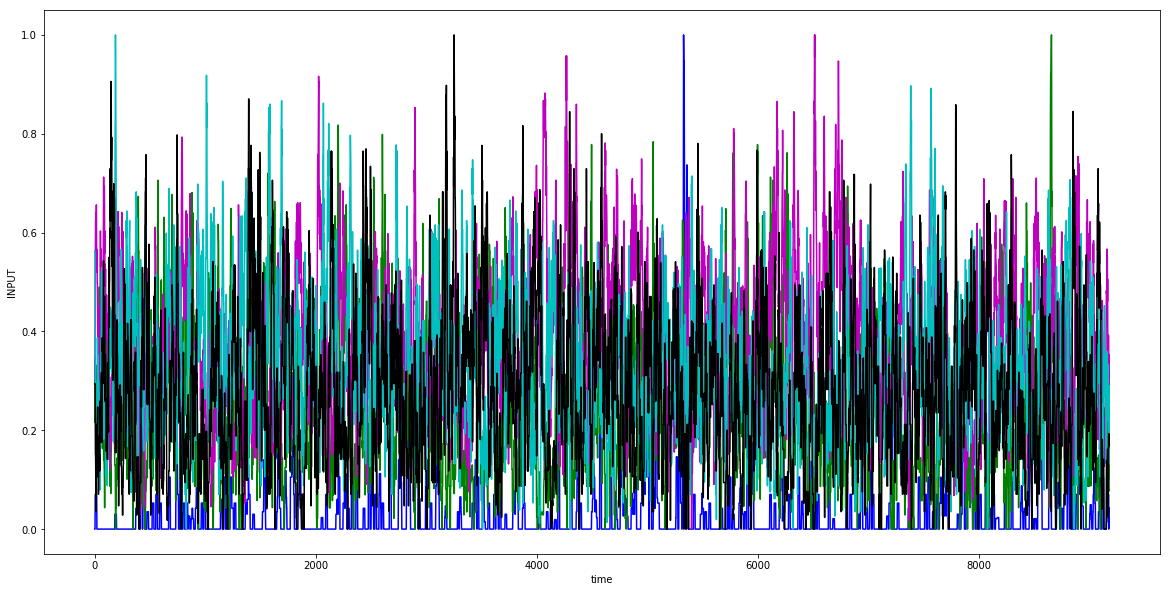

Alligning dataset and constructing cube..
.........................
number of training examples = 44
number of test examples = 139
X_train shape: (44, 39, 5)
Y_train shape: (44,)
X_test shape: (139, 39, 5)
Y_test shape: (139,)
Test baseline: 0.5971223021582733
.........................
Learning rate: 0.001
miniCost =0.8829827904701233
Epoch 0: 	Train cost: 0.8214875 	Dev cost: 0.6481923 	Train Accuracy: 0.84090906 	Dev accuracy: 0.34
miniCost =0.7162782549858093
Epoch 5: 	Train cost: 0.708657 	Dev cost: 0.6889919 	Train Accuracy: 0.8636364 	Dev accuracy: 0.34
miniCost =0.6965315937995911
Epoch 10: 	Train cost: 0.695414 	Dev cost: 0.6927922 	Train Accuracy: 0.8636364 	Dev accuracy: 0.34
miniCost =0.6933179497718811
Epoch 15: 	Train cost: 0.69308925 	Dev cost: 0.6930978 	Train Accuracy: 0.8636364 	Dev accuracy: 0.34
miniCost =0.6926040053367615
Epoch 20: 	Train cost: 0.69254106 	Dev cost: 0.69311285 	Train Accuracy: 0.8636364 	Dev accuracy: 0.34
miniCost =0.6923888921737671
Epoch 25: 	Tr

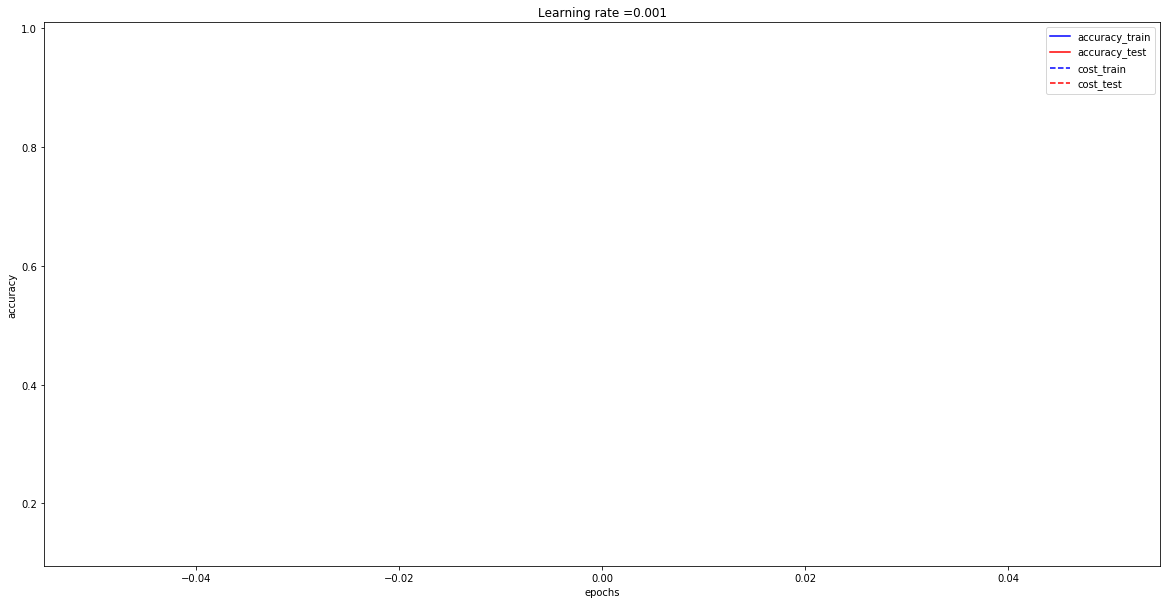

Train Accuracy: 0.13636364042758942
Test Accuracy: 0.6115108132362366


(0.13636364042758942, 0.6115108132362366)

In [22]:
### single run:
learning_rate=0.001
batch_size=512

# #################################

# BEST:
# Predicting the future at: [ 0.  1.  2.  3.  5. 10. 15. 30.] days  [0, 7, 14, 21, 35, 70, 105,210]
# best_NumLSTMUnits:            [379, 344, 890, 737, 273, 498, 916, 325]
# best_news_per_hour:            [32, 35, 40, 34, 36, 19, 22, 22]
# best_X_window_average:          [95, 74, 38, 12, 77, 48, 25, 41]


# accuracy_train = [0.96, 0.959, 0.962, 0.94, 0.93, 0.83]
# accuracy_test = [0.81, 0.927, 0.83, 0.64, 0.54, 0.4]
# #################################


# num_lstm_layers = 1
# num_lstm_units = 100
# news_per_hour = 30
# X_window_average = 10
# newsTimeToMarket = 0
num_lstm_layers = 1
num_lstm_units = 130
news_per_hour = 39
X_window_average = 15
newsTimeToMarket = 0



Data.load_data(news_per_hour = news_per_hour,
               X_window_average=X_window_average,
               momentum_window=30,
               newsTimeToMarket = newsTimeToMarket)
            

(X_train, Y_train) , (X_test, Y_test) = Data.get_train_test_set()
folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)
(X_train, Y_train), (X_dev, Y_dev) = folds[-1] 

test_x = tf.convert_to_tensor(np.asarray(X_test), dtype=tf.float32)
train_x = tf.convert_to_tensor(np.asarray(X_train), dtype=tf.float32)

train_y = tf.convert_to_tensor(np.asarray(Y_train), dtype=tf.float32)
test_y = tf.convert_to_tensor(np.asarray(Y_test), dtype=tf.float32)

print('.........................')
print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))
print ("Test baseline: " + str( np.sum(np.asarray(Y_test)==1)/len(Y_test)))
print('.........................')


model = MyModel(num_lstm_units=num_lstm_units, num_lstm_layers=num_lstm_layers, news_per_hour = news_per_hour,
                learning_rate = learning_rate, num_epochs = 30, minibatch_size = batch_size)

model.run(X_train,Y_train, X_dev, Y_dev, X_test, Y_test)



In [ ]:
Ttm_range = [ 0,  1,  2,  3,  5, 10, 15, 30]
train_accs = [0.782608687877655, 0.8426086902618408, 0.7408695816993713, 0.8895652294158936, 0.7260869741439819, 0.8408695459365845,0.678260862827301,0.678260862827301]
test_accs = [0.8133874535560608, 0.8215010166168213, 0.7606490850448608, 0.8580121994018555, 0.7444218993186951, 0.7910750508308411, 0.5841785073280334, 0.5841785073280334]


plt.figure(figsize=(20,10))

plt.plot(Ttm_range,train_accs,'b', label='accuracy_train')
plt.plot(Ttm_range,test_accs,'r', label='accuracy_test' )

plt.ylabel('accuracy')
plt.xlabel('days in the future')
#plt.title("Accuracy moving the window")
plt.legend()
plt.show()

In [ ]:
a =pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesHOLX.csv')